In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal, t
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data from CSV file
data = pd.read_csv('imdb_movies.csv')
data.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [3]:
data.describe()

,score,budget_x,revenue
count,10178.000000,1.017800e+04,1.017800e+04
mean,63.497052,6.488238e+07,2.531401e+08
std,13.537012,5.707565e+07,2.777880e+08
min,0.000000,1.000000e+00,0.000000e+00
25%,59.000000,1.500000e+07,2.858898e+07
50%,65.000000,5.000000e+07,1.529349e+08
75%,71.000000,1.050000e+08,4.178021e+08
max,100.000000,4.600000e+08,2.923706e+09


In [4]:
data['profit'] = data['revenue'] - data['budget_x']
data = data.loc[data['budget_x'] >= 1000000]
data = data.loc[data['revenue'] > 0]
data.score = data.score.apply(lambda x: round(x/10, 1))
data["genre"] = data['genre'].str.split(',').str[0]
data["orig_lang"] = data['orig_lang'].str.split(',').str[0]
data.head(3)

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,profit
0,Creed III,03/02/2023,7.3,Drama,"After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU,1.966167e+08
1,Avatar: The Way of Water,12/15/2022,7.8,Science Fiction,Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU,1.856795e+09
2,The Super Mario Bros. Movie,04/05/2023,7.6,Animation,"While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU,6.244590e+08


In [5]:
data.rename(columns = {'budget_x':'Budget', 'names':'Movie_name',
                        'genre':'Genre', 'score':'IMDb Rating',
                        'orig_lang':'Language', 'country':'Country',
                        'revenue':'Revenue', 'profit': 'Profit'}, inplace = True)

data.columns

Index(['Movie_name', 'date_x', 'IMDb Rating', 'Genre', 'overview', 'crew',
       'orig_title', 'status', 'Language', 'Budget', 'Revenue', 'Country',
       'Profit'],
      dtype='object')

In [6]:
data = data[['Movie_name', 'IMDb Rating', 'Genre', 'Language', 'Budget', 'Revenue', 'Country', 'Profit']]
data.head(3)

,Movie_name,IMDb Rating,Genre,Language,Budget,Revenue,Country,Profit
0,Creed III,7.3,Drama,English,75000000.0,2.716167e+08,AU,1.966167e+08
1,Avatar: The Way of Water,7.8,Science Fiction,English,460000000.0,2.316795e+09,AU,1.856795e+09
2,The Super Mario Bros. Movie,7.6,Animation,English,100000000.0,7.244590e+08,AU,6.244590e+08


<Figure size 1000x1200 with 0 Axes>

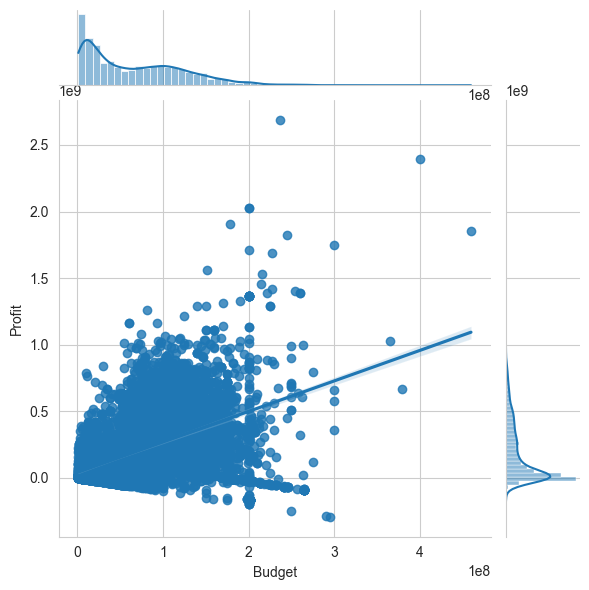

In [7]:
#Plot profit vs budget
sns.set_style("whitegrid")
plt.figure(figsize=[10,12])
sns.jointplot(x=data.Budget, y=data.Profit, kind='reg')
plt.show()

In [8]:
# Step 2: Joint Probability Distribution (JPD)
mean_budget_rating = data[['Budget', 'Profit']].mean()
cov_matrix = data[['Budget', 'Profit']].cov()
jpd = multivariate_normal(mean=mean_budget_rating, cov=cov_matrix)

# Step 3: Maximum Likelihood Estimate (MLE) for Correlation
genre_filtered_data = data[data['Genre'] == 'Action']  # Replace 'Action' with the desired genre
correlation_mle = genre_filtered_data[['Budget', 'Profit']].corr().iloc[0, 1]

# Step 4: Confidence Interval for Profit (with consideration of Language and Country)
budget_10m_filtered_data = data[(data['Budget'] == 10000000)] 
avg_profit = budget_10m_filtered_data['Profit'].mean()
standard_error = budget_10m_filtered_data['Profit'].sem()
confidence_interval = t.interval(0.95, len(budget_10m_filtered_data)-1, loc=avg_profit, scale=standard_error)

print(f"Joint Probability Distribution:{jpd.rvs()}")
print(f"Maximum Likelihood Estimate of Correlation for 'Action' genre: {correlation_mle:.2f}")
print(f"Confidence Interval for average Profit (Budget = $10M): {confidence_interval}")

Joint Probability Distribution:[25164786.47255799 81543142.74726513]
Maximum Likelihood Estimate of Correlation for 'Action' genre: 0.56
Confidence Interval for average Profit (Budget = $10M): (38141573.422222584, 56893508.22070424)


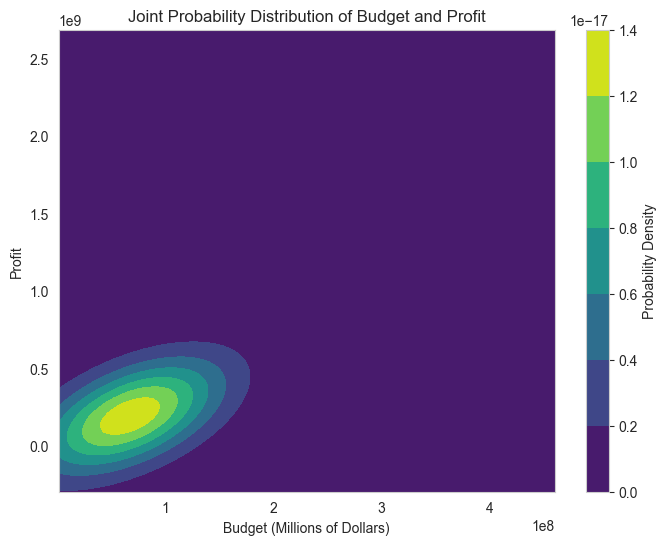

In [9]:
budget_values = np.linspace(data['Budget'].min(), data['Budget'].max(), 100)
profit_values = np.linspace(data['Profit'].min(), data['Profit'].max(), 100)
budget_grid, profit_grid = np.meshgrid(budget_values, profit_values)
positions = np.column_stack((budget_grid.ravel(), profit_grid.ravel()))

# Calculate the probability density at each point on the grid
pdf_values = jpd.pdf(positions).reshape(100, 100)

# Create a contour plot
plt.figure(figsize=(8, 6))
plt.contourf(budget_grid, profit_grid, pdf_values, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.xlabel('Budget (Millions of Dollars)')
plt.ylabel('Profit')
plt.title('Joint Probability Distribution of Budget and Profit')
plt.show()

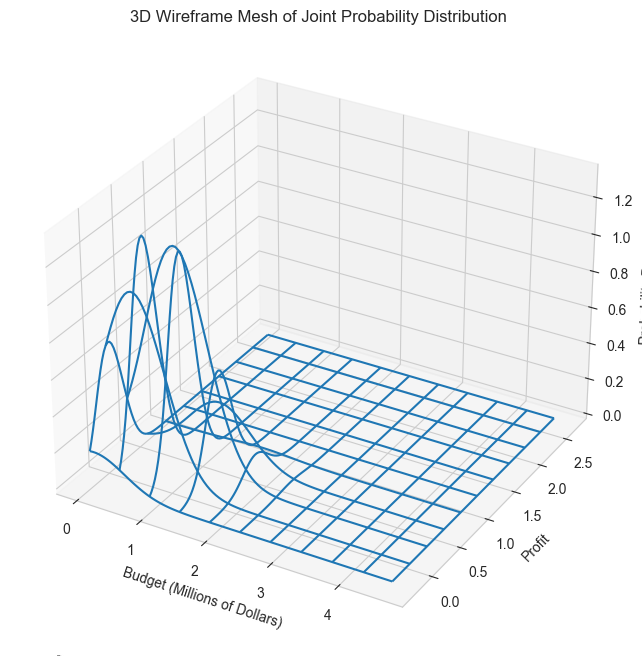

In [10]:
# Plotting the 3D Wireframe Mesh of the Joint Probability Distribution
budget_values = np.linspace(data['Budget'].min(), data['Budget'].max(), 100)
profit_values = np.linspace(data['Profit'].min(), data['Profit'].max(), 100)
budget_grid, profit_grid = np.meshgrid(budget_values, profit_values)
positions = np.column_stack((budget_grid.ravel(), profit_grid.ravel()))

# Calculate the probability density at each point on the grid
pdf_values = jpd.pdf(positions).reshape(100, 100)

# Create a 3D wireframe plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(budget_grid, profit_grid, pdf_values, rstride=10, cstride=10, cmap='viridis')
ax.set_xlabel('Budget (Millions of Dollars)')
ax.set_ylabel('Profit')
ax.set_zlabel('Probability Density')
ax.set_title('3D Wireframe Mesh of Joint Probability Distribution')
plt.show()

In [11]:
print(mean_budget_rating, cov_matrix)

Budget    6.693364e+07
Profit    1.939914e+08
dtype: float64               Budget        Profit
Budget  3.225327e+15  7.382834e+15
Profit  7.382834e+15  6.000950e+16


In [12]:
genre_filtered_data[['Budget', 'Profit']].corr()

,Budget,Profit
Budget,1.000000,0.562315
Profit,0.562315,1.000000


In [13]:
data.Budget = data.Budget.apply(lambda x: round(x/1000000, 2)) # changing budget to million $

In [14]:
# Step 2: Joint Probability Distribution (JPD)
mean_budget_rating = data[['Budget', 'IMDb Rating']].mean()
cov_matrix = data[['Budget', 'IMDb Rating']].cov()
jpd = multivariate_normal(mean=mean_budget_rating, cov=cov_matrix)

# Step 3: Maximum Likelihood Estimate (MLE) for Correlation
genre_filtered_data = data[data['Genre'] == 'Action']  # Replace 'Action' with the desired genre
correlation_mle = genre_filtered_data[['Budget', 'IMDb Rating']].corr().iloc[0, 1]

# Step 4: Confidence Interval for IMDb Rating (with consideration of Language and Country)
budget_10m_filtered_data = data[(data['Budget'] == 10.0)]
avg_imdb_rating = budget_10m_filtered_data['IMDb Rating'].mean()
standard_error = budget_10m_filtered_data['IMDb Rating'].sem()
confidence_interval = t.interval(0.95, len(budget_10m_filtered_data)-1, loc=avg_imdb_rating, scale=standard_error)

print(f"Joint Probability Distribution:\n{jpd.rvs()}")
print(f"Maximum Likelihood Estimate of Correlation for 'Action' genre: {correlation_mle:.2f}")
print(f"Confidence Interval for average IMDb Rating (Budget = $10M): {confidence_interval}")

Joint Probability Distribution:
[179.10634184   4.74978808]
Maximum Likelihood Estimate of Correlation for 'Action' genre: -0.08
Confidence Interval for average IMDb Rating (Budget = $10M): (6.280138878567465, 6.522787950700826)


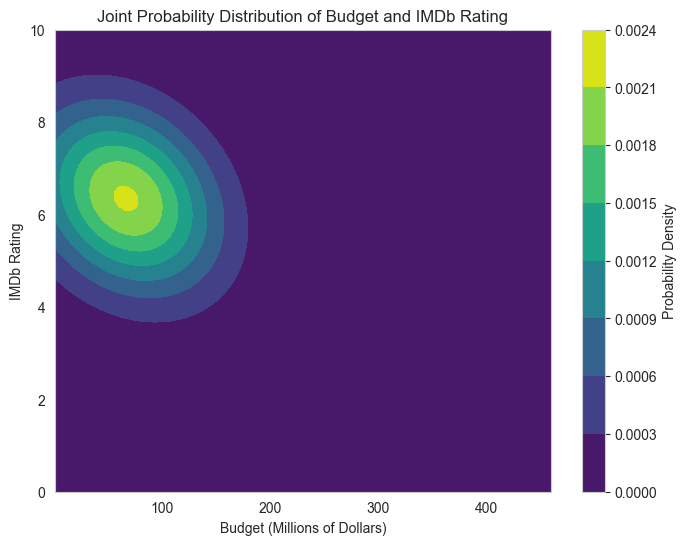

In [15]:
# Plotting the Joint Probability Distribution
# Create a grid of points for Budget and IMDb Rating
budget_values = np.linspace(data['Budget'].min(), data['Budget'].max(), 100)
imdb_rating_values = np.linspace(data['IMDb Rating'].min(), data['IMDb Rating'].max(), 100)
budget_grid, imdb_rating_grid = np.meshgrid(budget_values, imdb_rating_values)
positions = np.column_stack((budget_grid.ravel(), imdb_rating_grid.ravel()))

# Calculate the probability density at each point on the grid
pdf_values = jpd.pdf(positions).reshape(100, 100)

# Create a contour plot
plt.figure(figsize=(8, 6))
plt.contourf(budget_grid, imdb_rating_grid, pdf_values, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.xlabel('Budget (Millions of Dollars)')
plt.ylabel('IMDb Rating')
plt.title('Joint Probability Distribution of Budget and IMDb Rating')
plt.show()

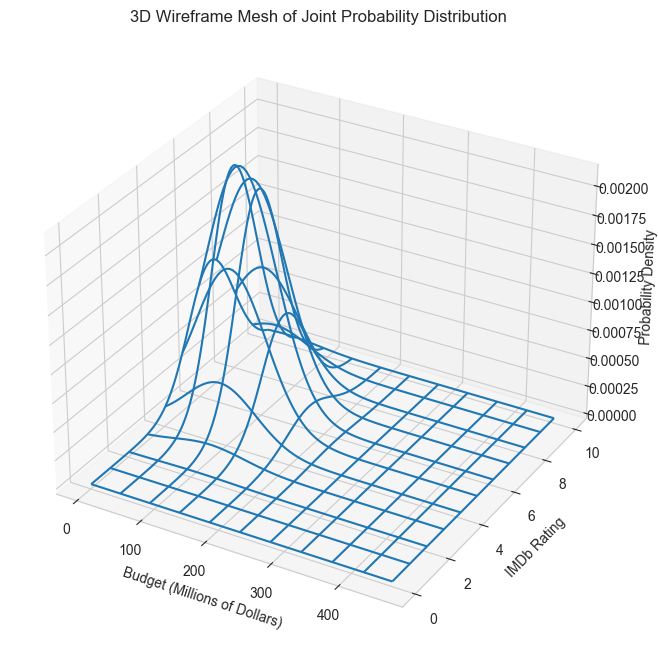

In [16]:
# Plotting the 3D Wireframe Mesh of the Joint Probability Distribution
budget_values = np.linspace(data['Budget'].min(), data['Budget'].max(), 100)
imdb_rating_values = np.linspace(data['IMDb Rating'].min(), data['IMDb Rating'].max(), 100)
budget_grid, imdb_rating_grid = np.meshgrid(budget_values, imdb_rating_values)
positions = np.column_stack((budget_grid.ravel(), imdb_rating_grid.ravel()))

# Calculate the probability density at each point on the grid
pdf_values = jpd.pdf(positions).reshape(100, 100)

# Create a 3D wireframe plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(budget_grid, imdb_rating_grid, pdf_values, rstride=10, cstride=10, cmap='viridis')
ax.set_xlabel('Budget (Millions of Dollars)')
ax.set_ylabel('IMDb Rating')
ax.set_zlabel('Probability Density')
ax.set_title('3D Wireframe Mesh of Joint Probability Distribution')
plt.show()

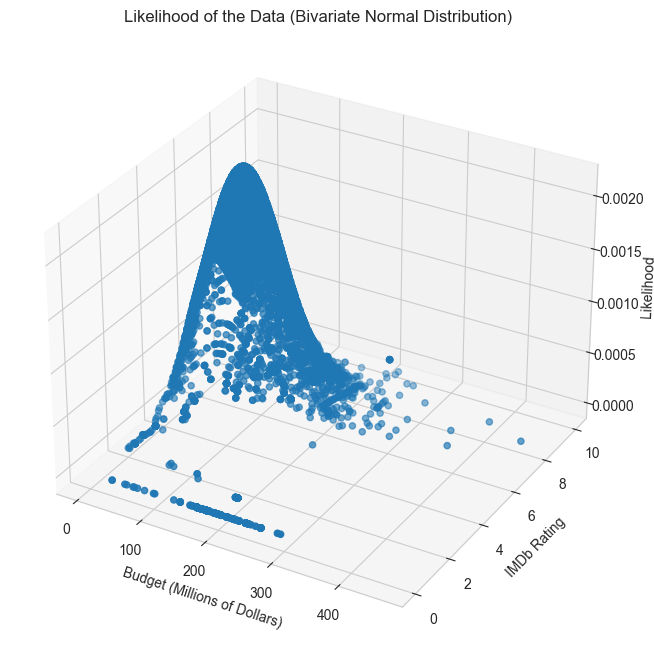

In [17]:
# Plotting the Likelihood of the Data (assuming bivariate normal distribution)
budget_values = data['Budget'].values
imdb_rating_values = data['IMDb Rating'].values
positions = np.column_stack((budget_values, imdb_rating_values))

# Calculate the likelihood (probability density) for each data point
likelihood_values = jpd.pdf(positions)

# Create a 3D scatter plot of the data points colored by likelihood
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(budget_values, imdb_rating_values, likelihood_values, cmap='viridis')
ax.set_xlabel('Budget (Millions of Dollars)')
ax.set_ylabel('IMDb Rating')
ax.set_zlabel('Likelihood')
ax.set_title('Likelihood of the Data (Bivariate Normal Distribution)')
plt.show()

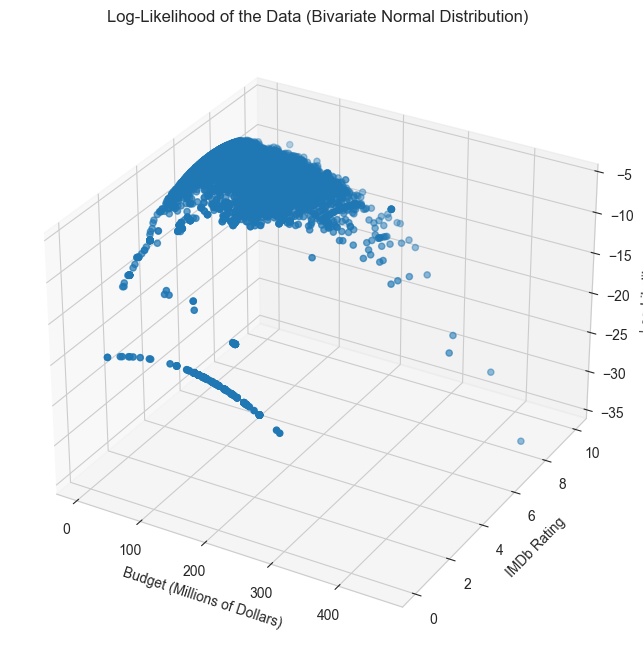

In [18]:
log_likelihood_values = np.log(likelihood_values)

# Create a 3D scatter plot of the data points colored by log-likelihood
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(budget_values, imdb_rating_values, log_likelihood_values, cmap='viridis')
ax.set_xlabel('Budget (Millions of Dollars)')
ax.set_ylabel('IMDb Rating')
ax.set_zlabel('Log-Likelihood')
ax.set_title('Log-Likelihood of the Data (Bivariate Normal Distribution)')
plt.show()